In [2]:
%pylab inline
#%matplotlib notebook
import xarray as xr
from glob import glob
from scipy import stats
import pandas as pd
#from xradd import *
from rrtmg_lw_functions import *
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
from string import ascii_lowercase
from scipy.interpolate import griddata
from netCDF4 import Dataset
from matplotlib.animation import FuncAnimation
import scipy.io
from scipy import interpolate
import time
from datetime import datetime
from datetime import timedelta 

Populating the interactive namespace from numpy and matplotlib


/aos/home/xwang/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Description

#### This notebook includes:
1. Explore the $\delta{T}=a*\delta{H2O}+b$ relationship and rrtmg results
2. Explore radiative effect of the cloud below the water vapor plumes

#### Conclusion from part 1: 

For most cases, (especially 90% of teh GEM data), the LW radiatvie effect of temperature anomaly dominates. Only when water vapor anomaly is extremely large, does its LW radiatvie effect beat that of temperature anomaly. But the extremely large water vapor anonalies are unlikely to happen (they are usually found near overshooting tops, freshly convectively transported water vapor)

#### Conclusion from part 2: 

The heating rate in the lower stratosphere is hardly affected by the cloud below.

cloud+water vapor plume vs no cloud+water vapor plume: When water vapor anomaly is extremely large, the cloud vs no cloud begins to show some difference. But the difference is negligible. For most cases, the cloud vs no cloud difference is even smaller.

But it is worth showing the absolue value of heating rates (instead of just delta heating rate) when comparing cloud vs no cloud. See bottom plots.

### 1. Explore the $\delta{T}=a*\delta{H2O}+b$ relationship and rrtmg results

#### Read pre-stored GEM deltaT vs deltaH2O distribution data

In [3]:
def sat_mix_mk(p,t):
    idx1 = np.where(t>273.5)
    if t>273.5:

        esi = np.exp(54.842763-6763.22/t-4.210*np.log(t) +\
        0.000367*t+np.tanh(0.0415*(t-218.8))*(53.878-1331.22/t - \
        9.44523*np.log(t)+0.014025*t))/ 100. # hPa
    if t<=273.5:

        esi = np.exp(9.550426-5723.265/t+3.53068*np.log(t)-0.00728332*t)/100.0 # hPa
    h2o=esi/(p-esi) # the mixing ratio
    if esi*100>p:
        h2o=esi/p
    if h2o>=1:
        h2o = np.nan
    return h2o*1e6

In [4]:
indir = '/storage/xwang/transfer_data/data/heating_rate_result_data/'
ttstr = '600'
ff = xr.open_dataset(indir+'GEM_'+ttstr+'m_1p0_100hPa_deltaT_deltaH2O_distribution.nc')

twmoist = ff.twmoist.data
twelse = ff.twelse.data
wvy = ff.delta_wv.data
ttx = ff.delta_t.data
tt90 = ff.t90.data
wv90 = ff.wv90.data
ff.close()

#### Get GEM data at 0001 min, the beginning of the model run (before convection), to compute the background mean for GEM

In [5]:
indir = '/storage/xwang/transfer_data/data/GEM_1p0_griddata/'
ffw0=xr.open_dataset(indir+'2013082512_0001m_1p0_h2o_mix_gz.nc')
ff0=xr.open_dataset(indir+'2013082512_0001m_1p0_tt_theta_thetav_gz.nc')
lat1 = 40;lat2=52
wv0=ffw0.h2o_mix.sel(lat=slice(lat1,lat2)).data
tt0=ff0.tt.sel(lat=slice(lat1,lat2)).data
alt = ff0.level.data

#lat1 = 45;lat2=52
lat = ff0.lat.sel(lat=slice(lat1,lat2)).data
lon=ff0.lon.data
nlat = np.size(lat)
nlon=np.size(lon)

iilev1 = 32 
iilev2 =37
print(alt[iilev1:iilev2+1],'km')
wvm0 = np.nanmean(wv0[iilev1:iilev2,:],axis=-1)
wvstd0 = np.nanstd(wv0[iilev1:iilev2,:],axis=-1)
ttm0 = np.nanmean(tt0[iilev1:iilev2,:],axis=-1)

[16.25 16.5  16.75 17.   17.25 17.5 ] km


#### Get Clausius Clapeyron curve

In [6]:
t_cc = np.arange(-20,5,1)
sat_cc = np.zeros_like(t_cc)
ttm0 = np.nanmean(tt0[iilev1:iilev2,:])
wvm0 = np.nanmean(wv0[iilev1:iilev2,:])
for i in range(len(t_cc)):
    sat_cc[i] = sat_mix_mk(100,t_cc[i]+ttm0)-wvm0

#### Pick a random point on the Clausius Clapeyron curve. Pick the mean point in the background $\delta{T}$ vs $\delta{H2O}$ distribution. Do a linear regression. 

In [7]:
### mean point in the background  delta 𝑇 vs  delta 𝐻2𝑂 distribution
itwelse = np.where(twelse==twelse.max())
telsem = ttx[itwelse[1]][0]
welsem = wvy[itwelse[0]][0]

In [8]:
#### Pick random points on the Clausius Clapeyron curve
#### Do a linear regression for each pair
xxt = np.arange(-15,-2,2)
yyw = np.array([0.])
for ii in xxt:
    iii = np.where(t_cc>=ii)[0][0]
    yyw = np.append(yyw,sat_cc[iii])
yyw = yyw[1:]
slps = np.zeros((len(xxt),2))
for ii in range(len(xxt)):
    slps[ii,:]=np.polyfit([xxt[ii],telsem],[yyw[ii],welsem],1)
    
xxtt = np.zeros((len(xxt),5))
yyww = np.zeros((len(xxt),5))
for i in range(len(xxt)):
    xxtt[i,:] = np.linspace(xxt[i],telsem,5)
    yyww[i,:] = xxtt[i,:]*slps[i,0]+slps[i,1]

#### Show the linear regressions

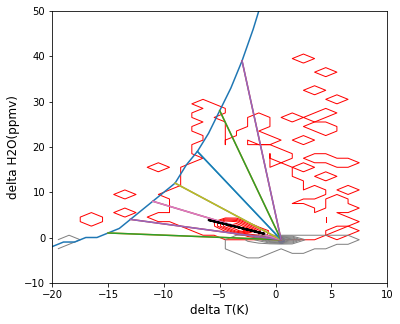

In [9]:
fig,ax = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(6,5, forward=True)

ax.plot(t_cc,sat_cc)
ax.contour(ttx,wvy,twmoist,colors='r',linewidths=1)
ax.contour(ttx,wvy,twelse,colors='grey',linewidths=1)

ax.set_xlabel('delta T(K)',fontsize=12)
ax.set_ylabel('delta H2O(ppmv)',fontsize=12)

ax.set_xlim([-20,10])
ax.set_ylim([-10,50])


#xxt = np.arange(195,207,2)
xxt = np.arange(-15,-2,2)
yyw = np.array([0.])
for ii in xxt:
    iii = np.where(t_cc>=ii)[0][0]
    yyw = np.append(yyw,sat_cc[iii])
yyw = yyw[1:]
ax.scatter(ttx[itwelse[1]],wvy[itwelse[0]],color='b')

for ii in range(len(xxt)):
    ax.plot(np.array([xxt[ii],telsem]),np.array([xxt[ii],telsem])*slps[ii][0]+slps[ii][1])
    ax.plot(xxtt[ii],yyww[ii])
    
slp = np.polyfit(tt90,wv90,1)
ax.plot(tt90,tt90*slp[0]+slp[1],color='k',linewidth=2)

#### Use an idealized overworld delta T profile to generate seven delta H2O profiles based on the seven $\delta{T}=a*\delta{H2O}+b$ linear fits

In [10]:
### Read base profiles and then add delta T or delta H2O to the base profiles

indir2 = '/storage/xwang/transfer_data/data/heating_rate_result_data/'
ff0 = xr.open_dataset(indir2+'idealized_gem_profiles_p_t_wv_perturb_base_radius_center_egde.nc')
p_ave = ff0.P_ave.data[0,0,:]
p_lev = ff0.P_lev.data[0,0,:]
gas_mr_wv = ff0.gas_mr_wv.data*1e6 # convert to ppmv
gas_mr_o3 = ff0.gas_mr_o3.data
T_ave = ff0.T_ave.data
T_lev = ff0.T_lev.data
ff0.close()

In [11]:
#### These are the idealized overworld delta T or delta H2O profiles
delt = np.zeros_like(p_ave)
delt[51:] = T_ave[0,1,51:]-T_ave[0,0,51:] 
delwv = np.zeros_like(p_ave)
delwv[51:] = gas_mr_wv[0,1,51:]-gas_mr_wv[0,0,51:]

In [12]:
#### generate delta H2O based on the seven $\delta{T}=a*\delta{H2O}+b$ linear fits
slps2 = np.append(slp[np.newaxis,:],slps,axis=0) ### append the slope from the regression of 90% data 
delt2 = np.ones((9,77))*delt
delwv2 = np.zeros_like(delt2)
delwv2[0,:] = delwv*1.
for i in range(1,9):
    delwv2[i,51:61] = delt2[i,51:61]*slps2[i-1,0]+slps2[i-1,1]

Text(0, 0.5, 'hPa')

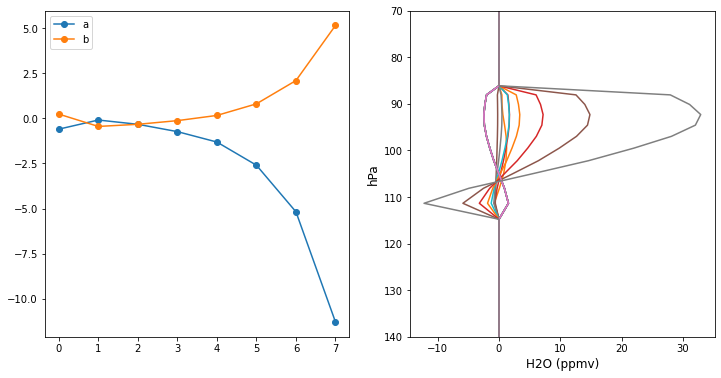

In [13]:
fig,ax = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(12,6, forward=True)
ax[0].plot(slps2[:,0],marker='o',label='a')
ax[0].plot(slps2[:,1],marker='o',label='b')
ax[0].legend()

ax[1].plot(delt2[0,:],p_ave) # this is for GEM data
ax[1].plot(delwv2[0,:],p_ave)

ax[1].plot(delt2[1,:],p_ave) # this is for GEM 90% data
ax[1].plot(delwv2[1,:],p_ave)
for i in range(2,9): # these are for the range of slopes
    ax[1].plot(delt2[i,:],p_ave)
    ax[1].plot(delwv2[i,:],p_ave)
    #ax.plot(delt2[i,51:]*slps[i,0]+slps[i,1],p_ave[51:])
ax[1].set_ylim([140,70])
ax[1].set_xlabel('H2O (ppmv)',fontsize=12)
ax[1].set_ylabel('hPa',fontsize=12)

#### Store the profiles for rrtmg

In [14]:
wvp = np.ones((3,10,77))*gas_mr_wv[:,0,:][:,np.newaxis,:]
wvp[:,1:,:] = wvp[:,1:,:]+delwv2[np.newaxis,:,:]
ttp = np.ones((3,10,77))*T_ave[:,0,:][:,np.newaxis,:]
ttp[:,1:,:] = ttp[:,1:,:]+delt2[np.newaxis,:,:]
ttlup = np.ones((3,10,78))*T_lev[:,0,:][:,np.newaxis,:]
ttldp = np.ones((3,10,78))*T_lev[:,0,:][:,np.newaxis,:]
ttlup[:,1:,52:] = ttlup[:,1:,52:]+delt2[np.newaxis,:,51:]
ttldp[:,1:,51:-1] = ttldp[:,1:,51:-1]+delt2[np.newaxis,:,51:]

wvp = wvp/1e6 # convert to mol/mol
P_ave = p_ave*np.ones_like(ttp)
P_lev = p_lev*np.ones_like(ttldp)

I have already saved the data and run the rrtmg. No need to run the codes below.

In [39]:
# ntype=3;npert = 10
# outdir = '/storage/xwang/transfer_data/data/heating_rate_result_data/'
# fout = Dataset(outdir+'idealized_gem_profiles_p_t_wv_slope_perturb_base.nc','w',format = 'NETCDF4')
# Level=fout.createDimension('level',77)
# Level2=fout.createDimension('level2',78)
# npp = fout.createDimension('npert',npert)
# nnt = fout.createDimension('ntype',ntype)
# outdata = fout.createVariable("gas_mr_wv",'f4',('ntype','npert','level'),zlib=True)
# outdata.units='mol/mol'

# outdata1 = fout.createVariable("T_ave",'f4',('ntype','npert','level'),zlib=True)
# outdata1.units='K'
# outdata2 = fout.createVariable("P_ave",'f4',('ntype','npert','level'),zlib=True)
# outdata2.units='hPa'
# outdata11 = fout.createVariable("T_lev_up",'f4',('ntype','npert','level2'),zlib=True)
# outdata11.units='K'
# outdata111 = fout.createVariable("T_lev_dw",'f4',('ntype','npert','level2'),zlib=True)
# outdata111.units='K'
# outdata21 = fout.createVariable("P_lev",'f4',('ntype','npert','level2'),zlib=True)
# outdata21.units='hPa'
# outdata3 = fout.createVariable("gas_mr_o3",'f4',('ntype','npert','level'),zlib=True)
# outdata3.units='mol/mol'

# Level=fout.createVariable("level",'f4',('level'),zlib=True)
# Level2=fout.createVariable("level2",'f4',('level2'),zlib=True)
# nnt=fout.createVariable("ntype",'S20',('ntype'),zlib=True)
# npp=fout.createVariable("npert",'S20',('npert'),zlib=True)

# outdata[:]=wvp
# outdata1[:]=ttp
# outdata2[:]=P_ave
# outdata11[:]=ttlup
# outdata111[:]=ttldp
# outdata21[:]=P_lev
# outdata3[:]=np.zeros_like(P_ave)*gas_mr_o3[0,0,:]

# Level[:]=np.arange(77)
# Level2[:]=np.arange(78)
# nnt[:]=np.array(['base','trop conv_e','trop_conv_c'])
# npp[:]=np.array(['base','gem','90%gem','1','2','3','4','5','6','7'])
# fout.close()


#### Show the rrtmg output for clear sky

In [15]:
indir1 = '/storage/xwang/transfer_data/data/heating_rate_result_data/rrtmg_retrieved_data/'
ff1 = glob(indir1+'idealized_gem_profiles_p_t_wv_slope_perturb_base_*_rrtmg_out.nc')
ff1.sort()
ff1 = ff1[3:]


### read data from the clear sky results only
fff = xr.open_dataset(ff1[5])
lw_hr_rr_t = fff.lw_hr.data[0,:]
sw_hr_rr_t = fff.sw_hr.data[0,:]
fff = xr.open_dataset(ff1[8])
lw_hr_rr_wv = fff.lw_hr.data[0,:]
sw_hr_rr_wv = fff.sw_hr.data[0,:]
fff = xr.open_dataset(ff1[2])
lw_hr_rr_b = fff.lw_hr.data[0,:]
sw_hr_rr_b = fff.sw_hr.data[0,:]

For most cases, (especially 90% of teh GEM data), the LW radiatvie effect of temperature anomaly dominates. Only when water vapor anomaly is extremely large, does its LW radiatvie effect beat that of temperature anomaly.

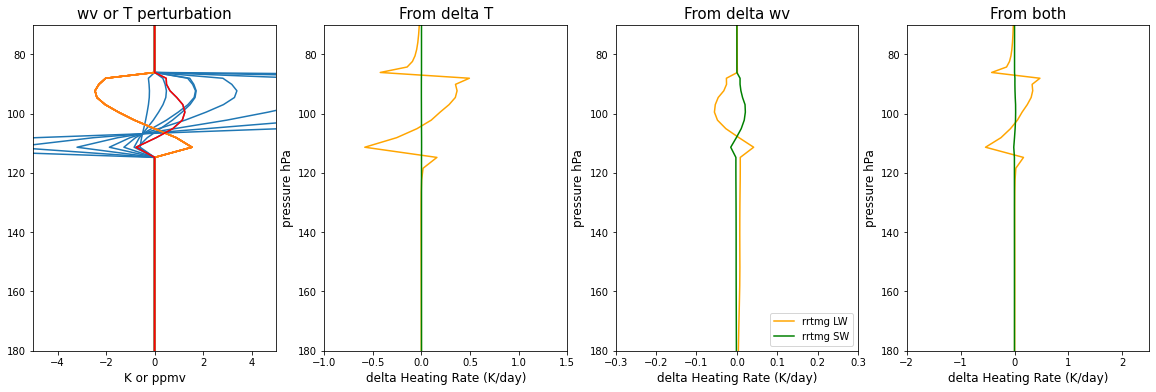

In [16]:
fig,ax = plt.subplots(nrows=1,ncols=4)
fig.set_size_inches(20,6, forward=True)
title = ['From delta T','From delta wv','From both']

for i in range(9):
    ax[0].plot(delwv2[i,:],p_ave,label='wv pert',color='tab:blue')
    ax[0].plot(delt2[i,:],p_ave,label='T_ave pert',color='tab:orange')
    ax[0].set_ylim([180,70])
    ax[0].set_title('wv or T perturbation',fontsize=15)
    ax[0].set_xlabel('K or ppmv',fontsize=12)

for j in range(1,4):   
    ax[j].set_title(title[j-1],fontsize=15)
    ax[j].set_xlabel('delta Heating Rate (K/day)',fontsize=12)
    ax[j].set_ylabel('pressure hPa',fontsize=12)

    ax[j].set_ylim([180,70])
    ax[j].set_xlim([-2,2.5])
ax[1].set_xlim([-1,1.5])
ax[0].set_xlim([-5,5])
ax[2].set_xlim([-0.3,0.3])
i0=0
ipt = 0


ipt=0  ### change ipt from 0 to 9 to show different rrtmg results depending on the magnitude of delta H2O 
       ### when ipt=6, the LW radiative effect from water vapor 
       ### is large enough to compensate for the LW temperature radiatvie effect
ax[1].plot(lw_hr_rr_t[ipt+1,1:]-lw_hr_rr_t[0,1:],p_ave[::-1],color='orange',linewidth=1.5,label='rrtmg LW')
ax[1].plot(sw_hr_rr_t[ipt+1,1:]-sw_hr_rr_t[0,1:],p_ave[::-1],color='g',linewidth=1.5,label='rrtmg SW')
ax[2].plot(lw_hr_rr_wv[ipt+1,1:]-lw_hr_rr_wv[0,1:],p_ave[::-1],color='orange',linewidth=1.5,label='rrtmg LW')
ax[2].plot(sw_hr_rr_wv[ipt+1,1:]-sw_hr_rr_wv[0,1:],p_ave[::-1],color='g',linewidth=1.5,label='rrtmg SW')
ax[3].plot(lw_hr_rr_b[ipt+1,1:]-lw_hr_rr_b[0,1:],p_ave[::-1],color='orange',linewidth=1.5,label='rrtmg LW')
ax[3].plot(sw_hr_rr_b[ipt+1,1:]-sw_hr_rr_b[0,1:],p_ave[::-1],color='g',linewidth=1.5,label='rrtmg SW')

ax[0].plot(delwv2[ipt,:],p_ave,label='wv pert',color='r')


ax[2].legend(loc='lower right')

## 2. Explore radiative effect of the cloud below the water vapor plumes

#### Read output of rrtmg runs that included cloud 

In [17]:
lw_hr_rr = np.zeros((9,10,78))
sw_hr_rr = np.zeros((9,10,78))
lw_uflux_rr = np.zeros((9,10,78))
sw_uflux_rr = np.zeros((9,10,78))
lw_dflux_rr = np.zeros((9,10,78))
sw_dflux_rr = np.zeros((9,10,78))
lw_nflux_rr = np.zeros((9,10,78))
sw_nflux_rr = np.zeros((9,10,78))
for i in range(9):
    fff = xr.open_dataset(ff1[i])
    
    i0=1 ### For tropospheric meteorology, read edge of convection. change i0 if need other options

    lw_hr_rr[i,:] = fff.lw_hr.data[i0,:]  
    sw_hr_rr[i,:] = fff.sw_hr.data[i0,:]
    lw_uflux_rr[i,:] = fff.lw_uflux.data[i0,:]
    sw_uflux_rr[i,:] = fff.sw_uflux.data[i0,:]
    lw_dflux_rr[i,:] = fff.lw_dflux.data[i0,:]
    sw_dflux_rr[i,:] = fff.sw_dflux.data[i0,:]
    lw_nflux_rr[i,:] = fff.lw_nflux.data[i0,:]
    sw_nflux_rr[i,:] = fff.sw_nflux.data[i0,:]

In [18]:
### read cloud data
indir11 = '/storage/xwang/transfer_data/data/heating_rate_result_data/'
f2 = xr.open_dataset(indir11+'idealized_gem_profiles_cloud_data_above_150hPa.nc')
iwc = f2.iwc.data
lwc = f2.lwc.data
efi = f2.efi.data
efr = f2.efr.data
clf =f2.clf.data
ems = f2.ems.data[0]
alb=f2.alb.data[0]
fsza = f2.sza.data

### Cloud minus no cloud.

The heating rate in the stratosphere is hardly affected by the cloud below

(1000.0, 70.0)

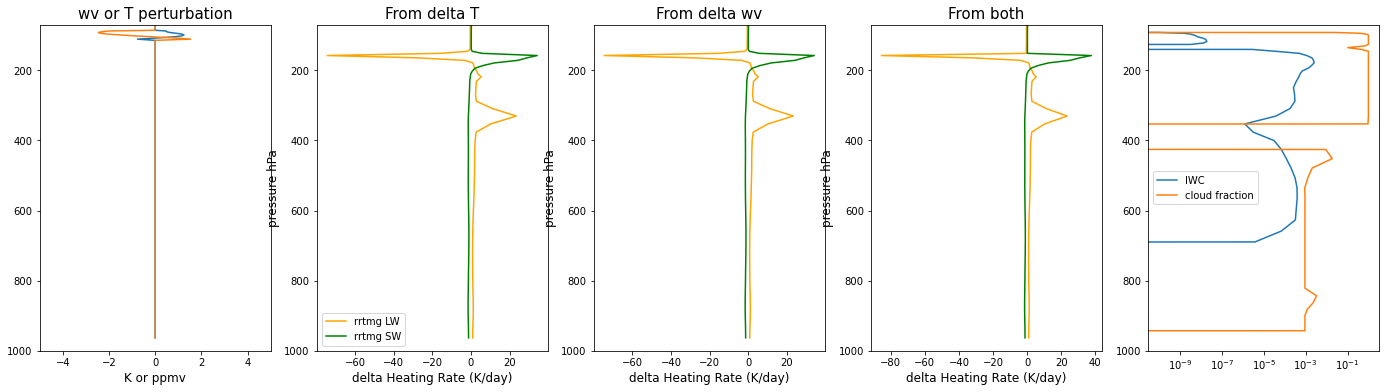

In [19]:
fig,ax = plt.subplots(nrows=1,ncols=5)
fig.set_size_inches(24,6, forward=True)
title = ['From delta T','From delta wv','From both']

ipt = 0
ax[0].plot(delwv2[ipt,:],p_ave,label='wv pert',color='tab:blue')
ax[0].plot(delt2[ipt,:],p_ave,label='T_ave pert',color='tab:orange')
#ax[0].set_ylim([150,70])
ax[0].set_ylim([1000,70])
ax[0].set_title('wv or T perturbation',fontsize=15)
ax[0].set_xlabel('K or ppmv',fontsize=12)
    
for j in range(1,4):   
    ax[j].set_title(title[j-1],fontsize=15)
    ax[j].set_xlabel('delta Heating Rate (K/day)',fontsize=12)
    ax[j].set_ylabel('pressure hPa',fontsize=12)

    ax[j].set_ylim([1000,70])
    #ax[j].set_xlim([-1,1.5])
#ax[1].set_xlim([-3,3.5])
ax[0].set_xlim([-5,5])    
    


ax[1].plot(lw_hr_rr[3,ipt,1:]-lw_hr_rr[5,ipt,1:],p_ave[::-1],color='orange',linewidth=1.5,label='rrtmg LW')
ax[1].plot(sw_hr_rr[3,ipt,1:]-sw_hr_rr[5,ipt,1:],p_ave[::-1],color='g',linewidth=1.5,label='rrtmg SW')
ax[2].plot(lw_hr_rr[6,ipt,1:]-lw_hr_rr[8,ipt,1:],p_ave[::-1],color='orange',linewidth=1.5,label='rrtmg LW')
ax[2].plot(sw_hr_rr[6,ipt,1:]-sw_hr_rr[8,ipt,1:],p_ave[::-1],color='g',linewidth=1.5,label='rrtmg SW')
ax[3].plot(lw_hr_rr[1,ipt,1:]-lw_hr_rr[2,ipt,1:],p_ave[::-1],color='orange',linewidth=1.5,label='rrtmg LW')
ax[3].plot(sw_hr_rr[1,ipt,1:]-sw_hr_rr[2,ipt,1:],p_ave[::-1],color='g',linewidth=1.5,label='rrtmg SW')

ax[1].legend()
ax[4].plot(iwc,p_ave,label='IWC')
ax[4].plot(clf,p_ave,label='cloud fraction')
ax[4].set_xscale('log')
ax[4].legend()
ax[4].set_ylim([1000,70])

##### Zoom in between pressure levels 150-70 hPa

(150.0, 70.0)

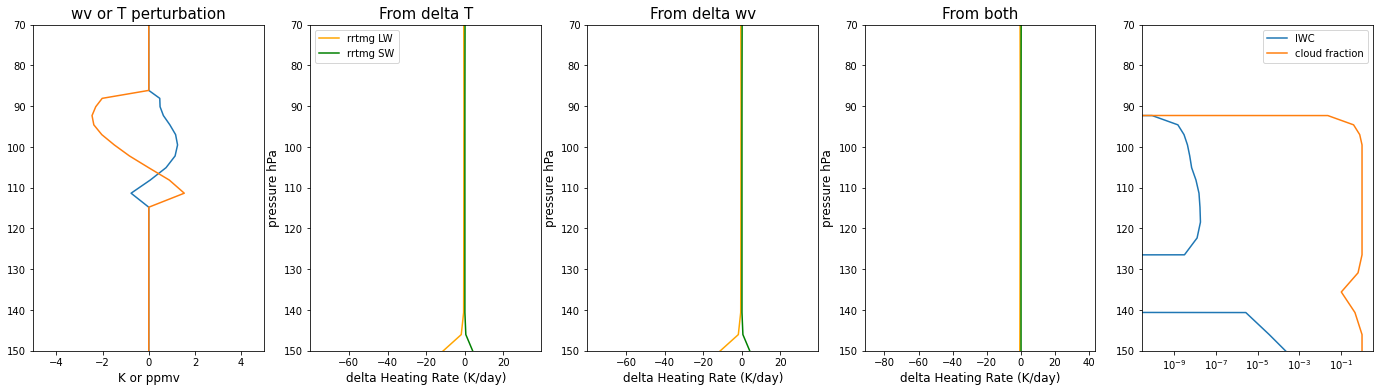

In [20]:
fig,ax = plt.subplots(nrows=1,ncols=5)
fig.set_size_inches(24,6, forward=True)
title = ['From delta T','From delta wv','From both']

ipt = 0
ax[0].plot(delwv2[ipt,:],p_ave,label='wv pert',color='tab:blue')
ax[0].plot(delt2[ipt,:],p_ave,label='T_ave pert',color='tab:orange')
ax[0].set_ylim([150,70])
#ax[0].set_ylim([1000,70])
ax[0].set_title('wv or T perturbation',fontsize=15)
ax[0].set_xlabel('K or ppmv',fontsize=12)
    
for j in range(1,4):   
    ax[j].set_title(title[j-1],fontsize=15)
    ax[j].set_xlabel('delta Heating Rate (K/day)',fontsize=12)
    ax[j].set_ylabel('pressure hPa',fontsize=12)

    #ax[j].set_ylim([1000,70])
    ax[j].set_ylim([150,70])
    #ax[j].set_xlim([-1,1.5])
#ax[1].set_xlim([-3,3.5])
ax[0].set_xlim([-5,5])    
    


ax[1].plot(lw_hr_rr[3,ipt,1:]-lw_hr_rr[5,ipt,1:],p_ave[::-1],color='orange',linewidth=1.5,label='rrtmg LW')
ax[1].plot(sw_hr_rr[3,ipt,1:]-sw_hr_rr[5,ipt,1:],p_ave[::-1],color='g',linewidth=1.5,label='rrtmg SW')
ax[2].plot(lw_hr_rr[6,ipt,1:]-lw_hr_rr[8,ipt,1:],p_ave[::-1],color='orange',linewidth=1.5,label='rrtmg LW')
ax[2].plot(sw_hr_rr[6,ipt,1:]-sw_hr_rr[8,ipt,1:],p_ave[::-1],color='g',linewidth=1.5,label='rrtmg SW')
ax[3].plot(lw_hr_rr[1,ipt,1:]-lw_hr_rr[2,ipt,1:],p_ave[::-1],color='orange',linewidth=1.5,label='rrtmg LW')
ax[3].plot(sw_hr_rr[1,ipt,1:]-sw_hr_rr[2,ipt,1:],p_ave[::-1],color='g',linewidth=1.5,label='rrtmg SW')

ax[1].legend()
ax[4].plot(iwc,p_ave,label='IWC')
ax[4].plot(clf,p_ave,label='cloud fraction')
ax[4].set_xscale('log')
ax[4].legend()
#ax[4].set_ylim([1000,70])
ax[4].set_ylim([150,70])

### cloud+water vapor plume vs no cloud+water vapor plume

When water vapor anomaly is extremely large, the cloud vs no cloud begins to show some difference. But the difference is negligible.
For most cases, the cloud vs no cloud difference is even smaller.

(140.0, 70.0)

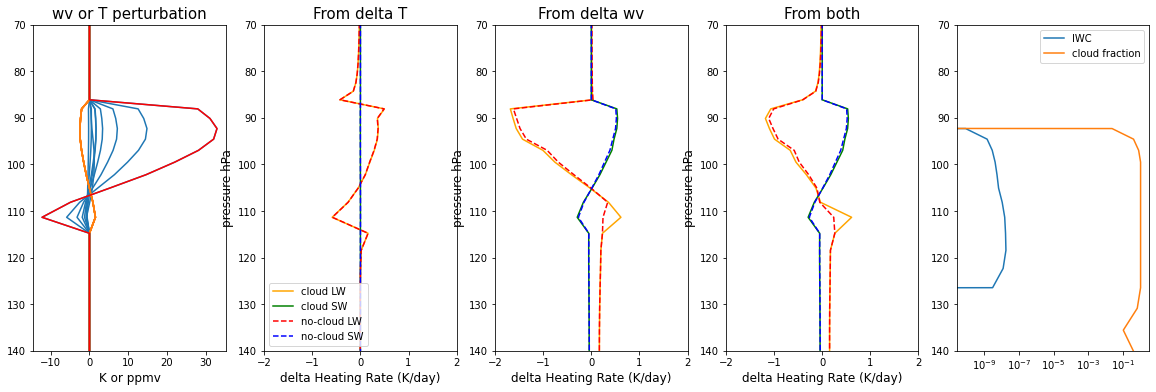

In [21]:
fig,ax = plt.subplots(nrows=1,ncols=5)
fig.set_size_inches(20,6, forward=True)
title = ['From delta T','From delta wv','From both']

for i in range(9):
    ax[0].plot(delwv2[i,:],p_ave,label='wv pert',color='tab:blue')
    ax[0].plot(delt2[i,:],p_ave,label='T_ave pert',color='tab:orange')
    ax[0].set_ylim([140,70])
    ax[0].set_title('wv or T perturbation',fontsize=15)
    ax[0].set_xlabel('K or ppmv',fontsize=12)
    
for j in range(1,4):   
    ax[j].set_title(title[j-1],fontsize=15)
    ax[j].set_xlabel('delta Heating Rate (K/day)',fontsize=12)
    ax[j].set_ylabel('pressure hPa',fontsize=12)

    ax[j].set_ylim([140,70])
    ax[j].set_xlim([-2,2])
#ax[0].set_xlim([-3,3.5])
    
    

ipt=9  ### change ipt from 1 to 8 to show different rrtmg results depending on the magnitude of delta H2O 
       ### when ipt=8, the cloud vs no cloud begins to show some difference. But the difference is negligible
       ### For most cases, the cloud vs no cloud difference is even smaller.
ax[0].plot(delwv2[ipt-1,:],p_ave,label='wv pert',color='r')

ax[1].plot(lw_hr_rr[3,ipt,1:]-lw_hr_rr[3,0,1:],p_ave[::-1],color='orange',linewidth=1.5,label='cloud LW')
ax[1].plot(sw_hr_rr[3,ipt,1:]-sw_hr_rr[3,0,1:],p_ave[::-1],color='g',linewidth=1.5,label='cloud SW')
ax[1].plot(lw_hr_rr[5,ipt,1:]-lw_hr_rr[5,0,1:],p_ave[::-1],color='r',linewidth=1.5,label='no-cloud LW',linestyle='--')
ax[1].plot(sw_hr_rr[5,ipt,1:]-sw_hr_rr[5,0,1:],p_ave[::-1],color='b',linewidth=1.5,label='no-cloud SW',linestyle='--')

ax[2].plot(lw_hr_rr[6,ipt,1:]-lw_hr_rr[6,0,1:],p_ave[::-1],color='orange',linewidth=1.5)
ax[2].plot(sw_hr_rr[6,ipt,1:]-sw_hr_rr[6,0,1:],p_ave[::-1],color='g',linewidth=1.5)
ax[2].plot(lw_hr_rr[8,ipt,1:]-lw_hr_rr[8,0,1:],p_ave[::-1],color='r',linewidth=1.5,linestyle='--')
ax[2].plot(sw_hr_rr[8,ipt,1:]-sw_hr_rr[8,0,1:],p_ave[::-1],color='b',linewidth=1.5,linestyle='--')

ax[3].plot(lw_hr_rr[0,ipt,1:]-lw_hr_rr[0,0,1:],p_ave[::-1],color='orange',linewidth=1.5)
ax[3].plot(sw_hr_rr[0,ipt,1:]-sw_hr_rr[0,0,1:],p_ave[::-1],color='g',linewidth=1.5)
ax[3].plot(lw_hr_rr[2,ipt,1:]-lw_hr_rr[2,0,1:],p_ave[::-1],color='r',linewidth=1.5,linestyle='--')
ax[3].plot(sw_hr_rr[2,ipt,1:]-sw_hr_rr[2,0,1:],p_ave[::-1],color='b',linewidth=1.5,linestyle='--')

ax[1].legend()

ax[4].plot(iwc,p_ave,label='IWC')
ax[4].plot(clf,p_ave,label='cloud fraction')
ax[4].set_xscale('log')
ax[4].legend()
ax[4].set_ylim([140,70])

#### But it is worth showing the absolue value of heating rates (instead of just delta heating rate)

Show the result for the perturbation from 90% GEM data.

First plot shows no cloud. Second plot is cloud included.

When cloud is not included, the heating rate from base run in lower stratosphere is ~0.3 K/day. Therefore when T and H2O perturbation is added, the heating rate in lower stratosphere is close to 1 K/day.

When cloud is included, the heating rate from base run in lower stratosphere is close to zero. Therefore when T and H2O perturbation is added, the heating rate in lower stratosphere is ~0.5 K/day.



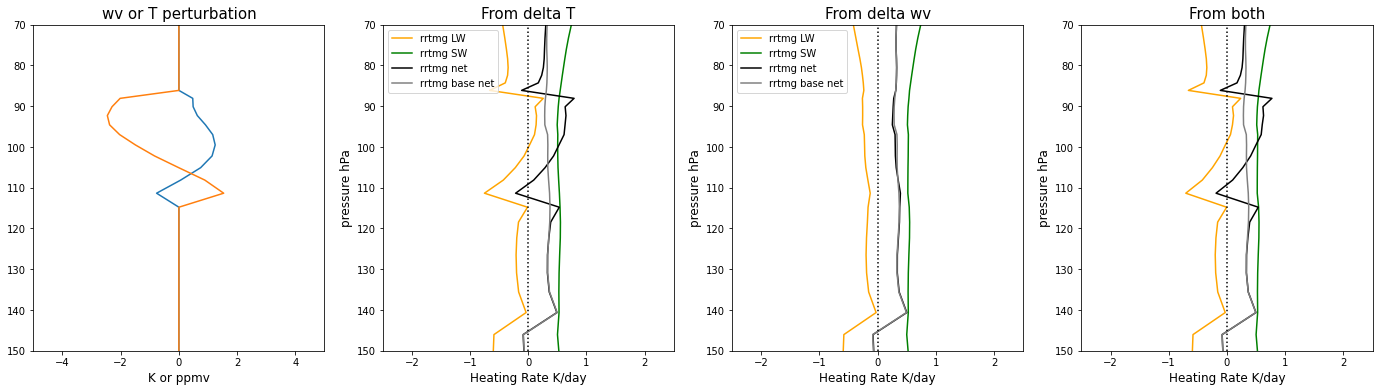

In [22]:
fig,ax = plt.subplots(nrows=1,ncols=4)
fig.set_size_inches(24,6, forward=True)
title = ['From delta T','From delta wv','From both']

ipt = 0
ax[0].plot(delwv2[ipt,:],p_ave,label='wv pert',color='tab:blue')
ax[0].plot(delt2[ipt,:],p_ave,label='T_ave pert',color='tab:orange')
ax[0].set_ylim([150,70])
ax[0].set_title('wv or T perturbation',fontsize=15)
ax[0].set_xlabel('K or ppmv',fontsize=12)
    
for j in range(1,4):   
    ax[j].set_title(title[j-1],fontsize=15)
    ax[j].set_xlabel('Heating Rate K/day',fontsize=12)
    ax[j].set_ylabel('pressure hPa',fontsize=12)

    ax[j].set_ylim([150,70])
    ax[j].set_xlim([-2.5,2.5])
#ax[1].set_xlim([-3,3.5])
ax[0].set_xlim([-5,5])    
    



ax[1].plot(lw_hr_rr[5,ipt+1,1:],p_ave[::-1],color='orange',linewidth=1.5,label='rrtmg LW')
ax[1].plot(sw_hr_rr[5,ipt+1,1:],p_ave[::-1],color='g',linewidth=1.5,label='rrtmg SW')
ax[1].plot(lw_hr_rr[5,ipt+1,1:]+sw_hr_rr[5,ipt+1,1:],p_ave[::-1],color='k',linewidth=1.5,label='rrtmg net')
ax[1].plot(lw_hr_rr[5,0,1:]+sw_hr_rr[5,0,1:],p_ave[::-1],color='grey',linewidth=1.5,label='rrtmg base net')
ax[1].plot([0,0],[150,70],color='k',linestyle=':')

ax[2].plot(lw_hr_rr[8,ipt+1,1:],p_ave[::-1],color='orange',linewidth=1.5,label='rrtmg LW')
ax[2].plot(sw_hr_rr[8,ipt+1,1:],p_ave[::-1],color='g',linewidth=1.5,label='rrtmg SW')
ax[2].plot(lw_hr_rr[8,ipt+1,1:]+sw_hr_rr[8,ipt+1,1:],p_ave[::-1],color='k',linewidth=1.5,label='rrtmg net')
ax[2].plot(lw_hr_rr[8,0,1:]+sw_hr_rr[8,0,1:],p_ave[::-1],color='grey',linewidth=1.5,label='rrtmg base net')
ax[2].plot([0,0],[150,70],color='k',linestyle=':')


ax[3].plot(lw_hr_rr[2,ipt+1,1:],p_ave[::-1],color='orange',linewidth=1.5,label='rrtmg LW')
ax[3].plot(sw_hr_rr[2,ipt+1,1:],p_ave[::-1],color='g',linewidth=1.5,label='rrtmg SW')
ax[3].plot(lw_hr_rr[2,ipt+1,1:]+sw_hr_rr[2,ipt+1,1:],p_ave[::-1],color='k',linewidth=1.5,label='rrtmg net')
ax[3].plot(lw_hr_rr[2,0,1:]+sw_hr_rr[2,0,1:],p_ave[::-1],color='grey',linewidth=1.5,label='rrtmg base net')
ax[3].plot([0,0],[150,70],color='k',linestyle=':')


ax[1].legend()
ax[2].legend()


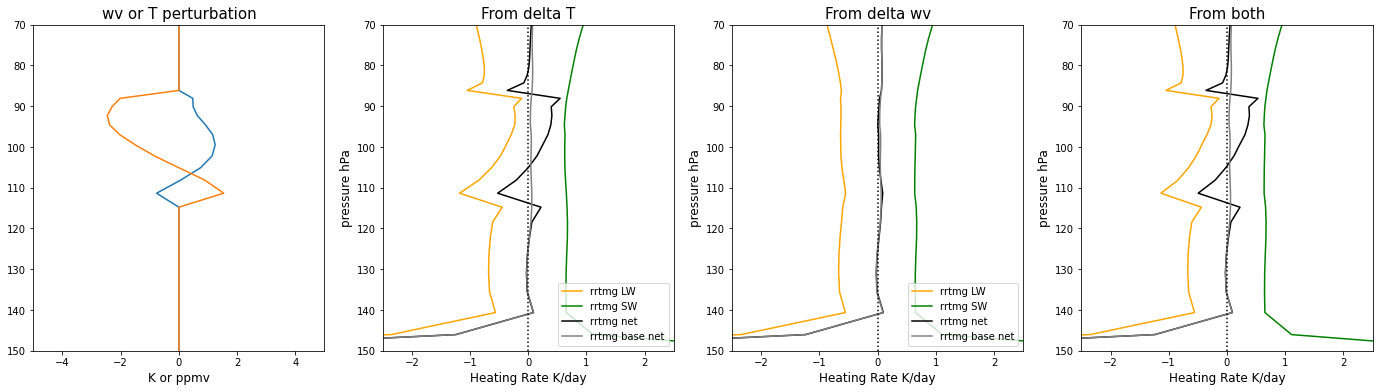

In [23]:
fig,ax = plt.subplots(nrows=1,ncols=4)
fig.set_size_inches(24,6, forward=True)
title = ['From delta T','From delta wv','From both']

ipt = 0
ax[0].plot(delwv2[ipt,:],p_ave,label='wv pert',color='tab:blue')
ax[0].plot(delt2[ipt,:],p_ave,label='T_ave pert',color='tab:orange')
ax[0].set_ylim([150,70])
ax[0].set_title('wv or T perturbation',fontsize=15)
ax[0].set_xlabel('K or ppmv',fontsize=12)
    
for j in range(1,4):   
    ax[j].set_title(title[j-1],fontsize=15)
    ax[j].set_xlabel('Heating Rate K/day',fontsize=12)
    ax[j].set_ylabel('pressure hPa',fontsize=12)

    ax[j].set_ylim([150,70])
    ax[j].set_xlim([-2.5,2.5])
#ax[1].set_xlim([-3,3.5])
ax[0].set_xlim([-5,5])    
    



ax[1].plot(lw_hr_rr[3,ipt+1,1:],p_ave[::-1],color='orange',linewidth=1.5,label='rrtmg LW')
ax[1].plot(sw_hr_rr[3,ipt+1,1:],p_ave[::-1],color='g',linewidth=1.5,label='rrtmg SW')
ax[1].plot(lw_hr_rr[3,ipt+1,1:]+sw_hr_rr[3,ipt+1,1:],p_ave[::-1],color='k',linewidth=1.5,label='rrtmg net')
ax[1].plot(lw_hr_rr[3,0,1:]+sw_hr_rr[3,0,1:],p_ave[::-1],color='grey',linewidth=1.5,label='rrtmg base net')
ax[1].plot([0,0],[150,70],color='k',linestyle=':')

ax[2].plot(lw_hr_rr[6,ipt+1,1:],p_ave[::-1],color='orange',linewidth=1.5,label='rrtmg LW')
ax[2].plot(sw_hr_rr[6,ipt+1,1:],p_ave[::-1],color='g',linewidth=1.5,label='rrtmg SW')
ax[2].plot(lw_hr_rr[6,ipt+1,1:]+sw_hr_rr[6,ipt+1,1:],p_ave[::-1],color='k',linewidth=1.5,label='rrtmg net')
ax[2].plot(lw_hr_rr[6,0,1:]+sw_hr_rr[6,0,1:],p_ave[::-1],color='grey',linewidth=1.5,label='rrtmg base net')
ax[2].plot([0,0],[150,70],color='k',linestyle=':')


ax[3].plot(lw_hr_rr[0,ipt+1,1:],p_ave[::-1],color='orange',linewidth=1.5,label='rrtmg LW')
ax[3].plot(sw_hr_rr[0,ipt+1,1:],p_ave[::-1],color='g',linewidth=1.5,label='rrtmg SW')
ax[3].plot(lw_hr_rr[0,ipt+1,1:]+sw_hr_rr[0,ipt+1,1:],p_ave[::-1],color='k',linewidth=1.5,label='rrtmg net')
ax[3].plot(lw_hr_rr[0,0,1:]+sw_hr_rr[0,0,1:],p_ave[::-1],color='grey',linewidth=1.5,label='rrtmg base net')
ax[3].plot([0,0],[150,70],color='k',linestyle=':')


ax[1].legend()
ax[2].legend()
